In [68]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

from skimage.io import imshow
from skimage.io import imread
from skimage.data import imread
from skimage.segmentation import find_boundaries
from skimage.segmentation import mark_boundaries
from skimage.morphology import binary_opening, disk
from skimage.morphology import label
# from skimage.measure import label
from skimage.measure import regionprops
from scipy import ndimage as ndi

from skimage.util import montage

from keras import backend as K
from keras.models import load_model
from utils import make_image_gen
from utils import rle_encode
from utils import rle_decode
from utils import soft_dice_coef
from utils import fbeta
from utils import iou
from utils import recall
from utils import multi_rle_encode
from utils import masks_as_image

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

In [4]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
# ship_dir = '../input'
ship_dir = "/media/Borg_LS/DATA/geos/airbus/input/"
print(os.listdir(ship_dir))
train_image_dir = os.path.join(ship_dir, 'train_768')
test_image_dir = os.path.join(ship_dir, 'test_v2')

df = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2_cleaned.csv'))
# df = df.dropna()
print(df.shape[0], 'masks found')
print(df['ImageId'].value_counts().shape[0])
df.head()

['background_96_24.csv', 'hard_negatives_384_400_2.png', 'delme', 'duplicates.csv', 'hard_negatives_384_400_11.png', 'hard_negatives_384_400_16.png', 'hard_negatives_384_400_1.png', 'train_ship_segmentations_v2.csv', 'fullmasks_192_all.csv', 'fullmasks_384.csv', 'models', 'hard_negatives_384_400_19.png', 'fullmasks_384_down_192.csv', 'hard_negatives_384_400_15.png', 'train_ship_segmentations2.csv', 'fullmasks_96.csv', 'hard_negatives_384_400_14.png', 'fullmasks_384_down_96.csv', 'hard_negatives_384_400_6.png', 'train_masks_768', 'hard_negatives_384_400_9.png', 'fullmasks_192_down_96.csv', 'train_96', 'hard_negatives_384_400_12.png', 'fullmasks_192.csv', 'train_384', 'fullmasks_768_down_192.csv', 'sample_submission_v2.csv', 'train_192', 'mask_1_thick_0.5', 'hard_negatives_384_400_7.png', 'hard_negatives_384_400_10.png', 'hard_negatives_384_400_13.png', 'hard_negatives_384_400_4.png', 'background_768.csv', 'fullmasks_384_all.csv', 'fullmasks_768.csv', 'fullmasks_96.h5', 'tmp', 'hard_nega

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [4]:
from sklearn.model_selection import train_test_split
unique_img_ids = df.groupby('ImageId').size().reset_index(name='counts')
train_ids, valid_ids = train_test_split(unique_img_ids, test_size = 0.1, stratify = unique_img_ids['counts'])
train_df = pd.merge(df, train_ids)
valid_df = pd.merge(df, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

117929 training masks
13101 validation masks


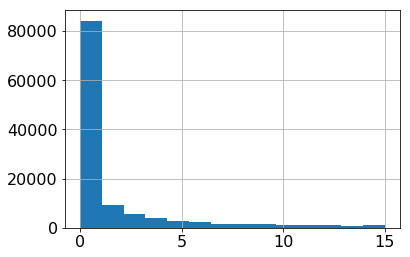

In [5]:
train_df['counts'] = train_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)
train_df['counts'].hist(bins=14)

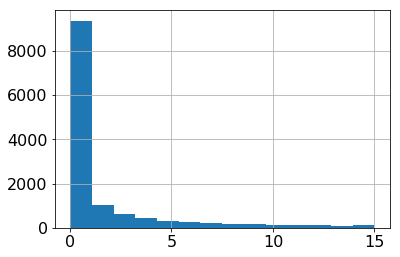

In [6]:
valid_df['counts'] = valid_df.apply(lambda c_row: c_row['counts'] if isinstance(c_row['EncodedPixels'], str) else 0, 1)
valid_df['counts'].hist(bins=14)

In [7]:
train_df = train_df[train_df['counts'] >= 11]
valid_df = valid_df[valid_df['counts'] >= 11]

In [8]:
Counter(valid_df['counts'])

Counter({11: 110, 13: 78, 15: 75, 12: 108, 14: 70})

In [18]:
from utils import read_stacked_masks

In [2]:
def recall(y_true, y_pred):
    return K.sum(K.flatten(y_true) * K.flatten(K.round(y_pred))) / K.sum(y_true)

In [8]:
ships_model = load_model('ships_model_104.h5', custom_objects={'dice': soft_dice_coef, 'recall': recall})

In [9]:
BATCH_SIZE = 9

In [10]:
valid_gen = make_image_gen(valid_df, train_image_dir, batch_size=BATCH_SIZE, print_meta=True)

In [99]:
x_valid_batch, y_valid_batch = next(valid_gen)
print('x', x_valid_batch.shape, x_valid_batch.min(), x_valid_batch.max(), x_valid_batch[0, 0, 0])
print('y', y_valid_batch.shape, y_valid_batch.min(), y_valid_batch.max(), y_valid_batch[0, 0, 0])

y_hat_batch = ships_model.predict(x_valid_batch)

0 3c027498a.jpg [13 13 13 13 13 13 13 13 13 13 13 13 13]
1 333e9327d.jpg [13 13 13 13 13 13 13 13 13 13 13 13 13]
2 ae7bb3713.jpg [14 14 14 14 14 14 14 14 14 14 14 14 14 14]
3 87b0956c6.jpg [11 11 11 11 11 11 11 11 11 11 11]
4 2c1b309f8.jpg [11 11 11 11 11 11 11 11 11 11 11]
5 658bf62a0.jpg [11 11 11 11 11 11 11 11 11 11 11]
6 754326edc.jpg [14 14 14 14 14 14 14 14 14 14 14 14 14 14]
7 3612dbf3d.jpg [12 12 12 12 12 12 12 12 12 12 12 12]
8 d355bcf51.jpg [11 11 11 11 11 11 11 11 11 11 11]
x (9, 768, 768, 3) 0.0 1.0 [0.12156863 0.23529412 0.25882353]
y (9, 768, 768, 1) 0 1 [0]


Text(0.5,1,'Outlined Ships')

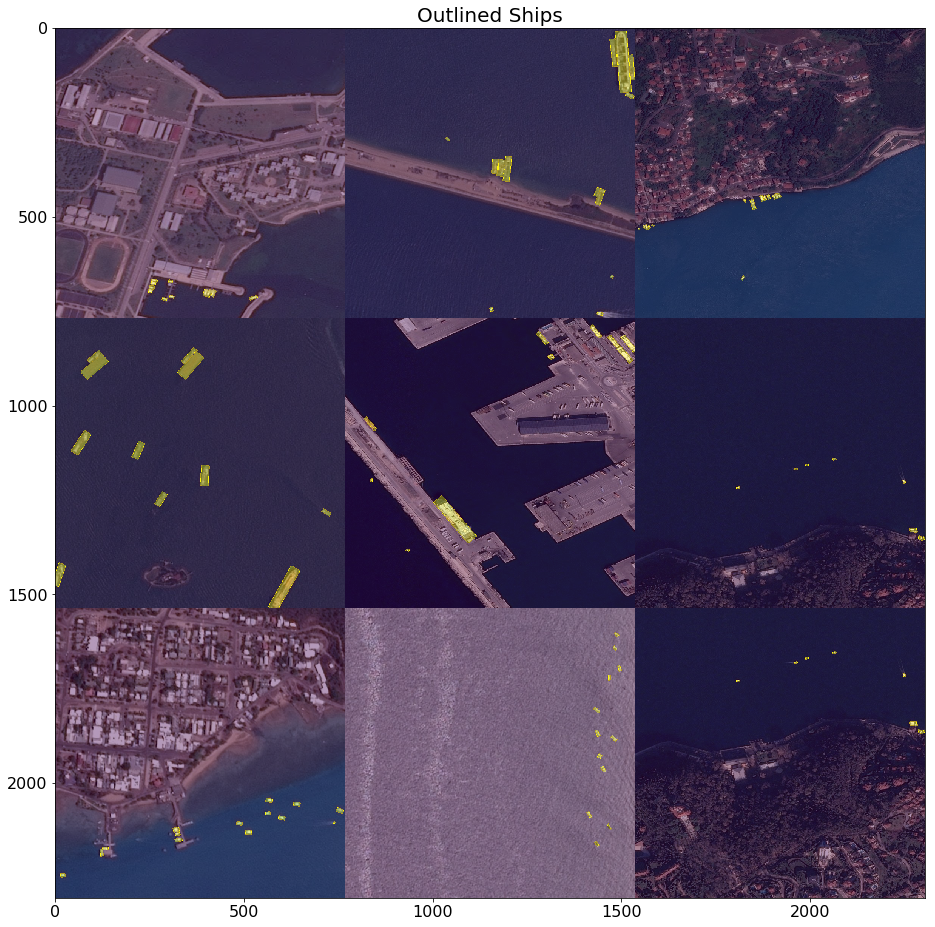

In [100]:
fig, ax = plt.subplots(1, 1, figsize = (16, 16))
batch_rgb = montage_rgb(x_valid_batch)
batch_seg = montage(y_valid_batch[:, :, :, 0])
ax.imshow(mark_boundaries(batch_rgb, batch_seg.astype(int)))
ax.imshow(batch_seg, alpha=0.4)
ax.set_title('Outlined Ships')

Text(0.5,1,'Predictions')

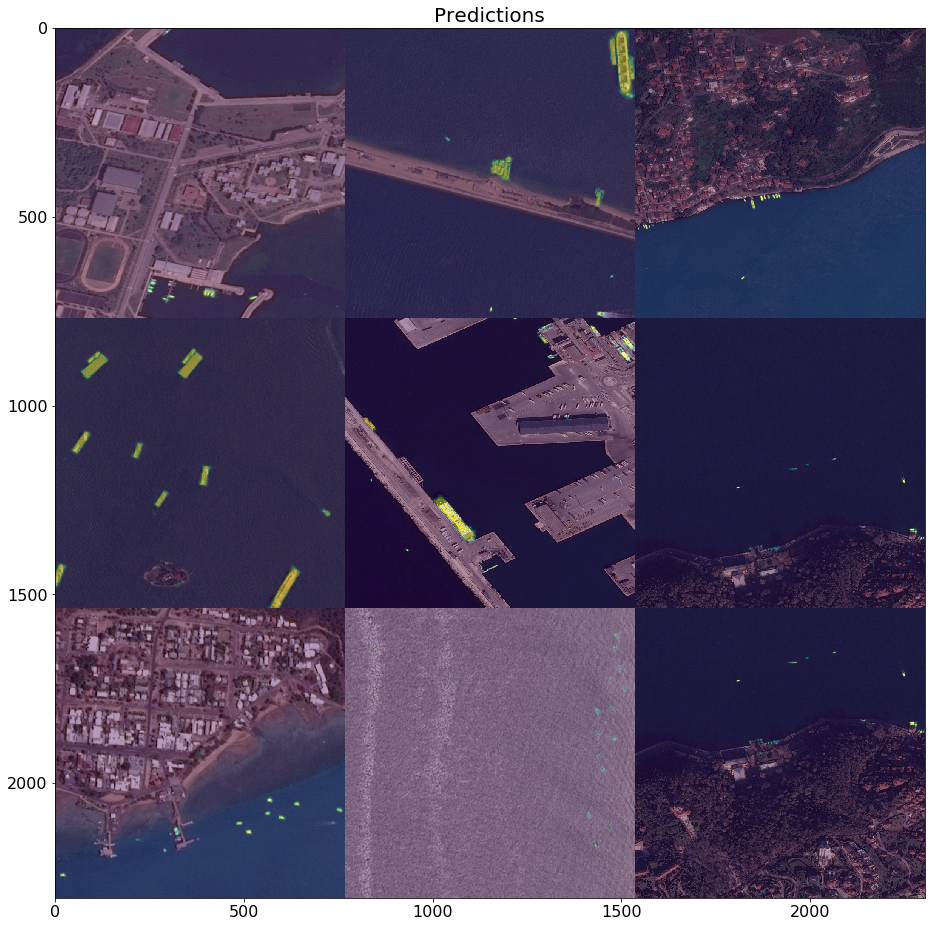

In [101]:
fig, ax = plt.subplots(1, 1, figsize = (16, 16))
batch_rgb = montage_rgb(x_valid_batch)
batch_seg = montage(y_hat_batch[:, :, :, 0])
ax.imshow(mark_boundaries(batch_rgb, batch_seg.astype(int)))
ax.imshow(batch_seg, alpha=0.4)
ax.set_title('Predictions')

img     5 255 (768, 768, 3)
y_valid 0.0 1.0 (768, 768)
x_valid 0.0196078431372549 1.0 (1, 768, 768, 3)
y_hat   4.137135e-12 0.92795324 (1, 768, 768, 1)

i   t  pred true  n  y cur    rec     iou    dice      f2
---------------------------------------------------------
0 0.1  2103 1193 12 16 15 0.88433 0.47077 0.64017 0.76727
1 0.2  1341 1193 12 14 14 0.70662 0.49852 0.66535 0.68951
2 0.3   959 1193 12 13 13 0.54987 0.43850 0.60967 0.57233
3 0.4   694 1193 12 13 12 0.41827 0.35951 0.52888 0.45646
4 0.5   489 1193 12 13  9 0.31266 0.28495 0.44352 0.35450
5 0.6   311 1193 12 11  6 0.21291 0.20320 0.33777 0.24985
6 0.7   168 1193 12  7  3 0.11819 0.11557 0.20720 0.14271
7 0.8    57 1193 12  6  0 0.04191 0.04167 0.08000 0.05177
8 0.9     7 1193 12  2  0 0.00587 0.00587 0.01167 0.00732


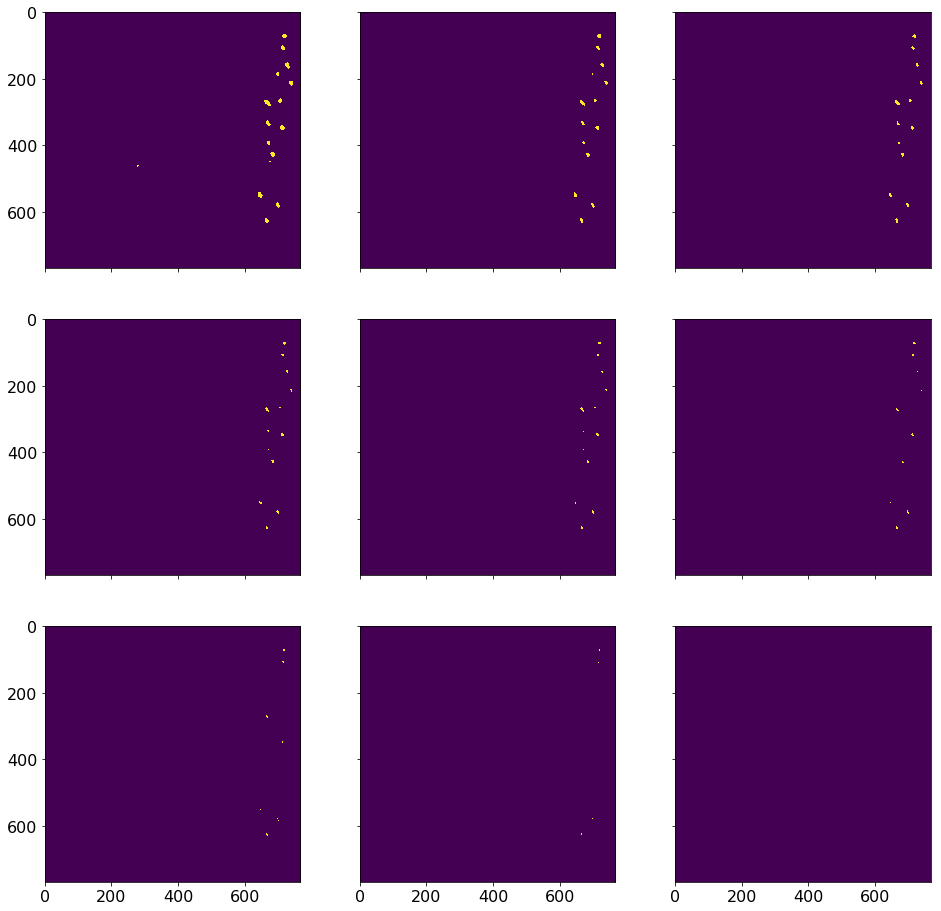

In [108]:
ImageId = '87b0956c6.jpg'
ImageId = '3612dbf3d.jpg'
img = imread(os.path.join(train_image_dir, ImageId))
print('img    ', np.min(img), np.max(img), img.shape)

# enc_masks = train_df.loc[train_df['ImageId'] == ImageId, 'EncodedPixels'].tolist()

mask_list = read_stacked_masks(ImageId)
y_valid =  np.sum(mask_list, axis=0)
print('y_valid', np.min(y_valid), np.max(y_valid), y_valid.shape)

# merged_masks = np.zeros((768, 768))
# for i, mask in enumerate(mask_list):
#     merged_masks += (mask * (i + 1))

x_valid = np.expand_dims(img, 0) / 255.0
print('x_valid', np.min(x_valid), np.max(x_valid), x_valid.shape)
y_hat = ships_model.predict(x_valid)
print('y_hat  ', np.min(y_hat), np.max(y_hat), y_hat.shape)
print('')
print('i   t  pred true  n  y cur    rec     iou    dice      f2')
print('---------------------------------------------------------')
fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize = (16, 16))
# fig.set_size_inches(20, 20)
for i in range(9):
    col = i % 3
    row = i // 3
    iou_thresh = (i + 1) / 10.0
    
    y_detect = (y_hat[0] > iou_thresh) * 1
    y_labels = label(y_detect[:, :, 0])
    
    y_rles = multi_rle_encode(y_detect)
    len_y_rles = len(y_rles)
    
    cur_seg = binary_opening(y_hat[0] > iou_thresh, np.expand_dims(disk(2), -1))
    cur_labels = label(cur_seg[:, :, 0])
    
    cur_rles = multi_rle_encode(cur_seg)
    len_cur_rles = len(cur_rles)
    
    rec_txt = f'{recall(y_valid, y_detect[..., 0]):>.5f}'
    iou_txt = f'{iou(y_valid, y_detect[..., 0]):>.5f}'
    dic_txt = f'{soft_dice_coef(y_valid, y_detect[..., 0]):>.5f}'
    f2_txt = f'{fbeta(y_valid, y_detect[..., 0], 2.0):>.5f}'
    print(i, iou_thresh, f'{np.sum(y_detect[..., 0]):>5}', np.sum(y_valid).astype(int), f'{len(mask_list):>2}', f'{len_y_rles:>2}', f'{len_cur_rles:>2}', rec_txt, iou_txt, dic_txt, f2_txt)
#     print('y_rles  ', len_y_rles, [np.sum(p) for p in y_rles])
#     print('cur_rles', len_cur_rles, [np.sum(p) for p in cur_rles])
#     ax[row, col].imshow(img)
    ax[row, col].imshow(y_detect[..., 0]) #, alpha=0.4)
#     ax[row, col].imshow(y_labels) #, alpha=0.4)
#     ax[row, col].imshow(cur_seg[..., 0]) #, alpha=0.4)
#     ax[row, col].imshow(cur_labels) #, alpha=0.4)

In [72]:
len(y_rles[0])

238

In [ ]:
n = 8
iou_thresh = 0.75
i_paths = np.random.choice(len(test_paths), n)
t_paths = test_paths[i_paths]
fig, m_axs = plt.subplots(n, 3, figsize = (10, 40))
for (ax1, ax2, ax3), c_img_name in zip(m_axs, test_paths):
    c_path = os.path.join(test_image_dir, c_img_name)
    c_img = imread(c_path)
    first_img = np.expand_dims(c_img, 0)/255.0
    first_seg = seg_model.predict(first_img)
    first_f = (first_seg > iou_thresh) * 1
    ax1.imshow(first_img[0])
    ax1.set_title('Image')
    ax2.imshow(first_seg[0, :, :, 0])
    ax2.set_title('Prediction')
    ax3.imshow(first_f[0, :, :, 0])
    ax3.set_title(f'IOU thresh = {iou_thresh:>.2f}')

In [110]:
image_with_ships = '929e28f93.jpg'
image_with_no_ships = '1fbc5de57.jpg'

In [111]:
ImageId = '929e28f93.jpg'

img = imread(os.path.join(train_image_dir, ImageId))
enc_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

mask_list = read_stacked_masks(ImageId)
# all_masks = np.zeros((768, 768))
# for mask in img_masks:
#     all_masks += rle_decode(mask)
all_masks =  np.sum(mask_list, axis=0)

merged_masks = np.zeros((768, 768))
for i, mask in enumerate(mask_list):
    merged_masks += (mask * (i+1))

In [29]:
y_hat = ships_model.predict(x_valid)

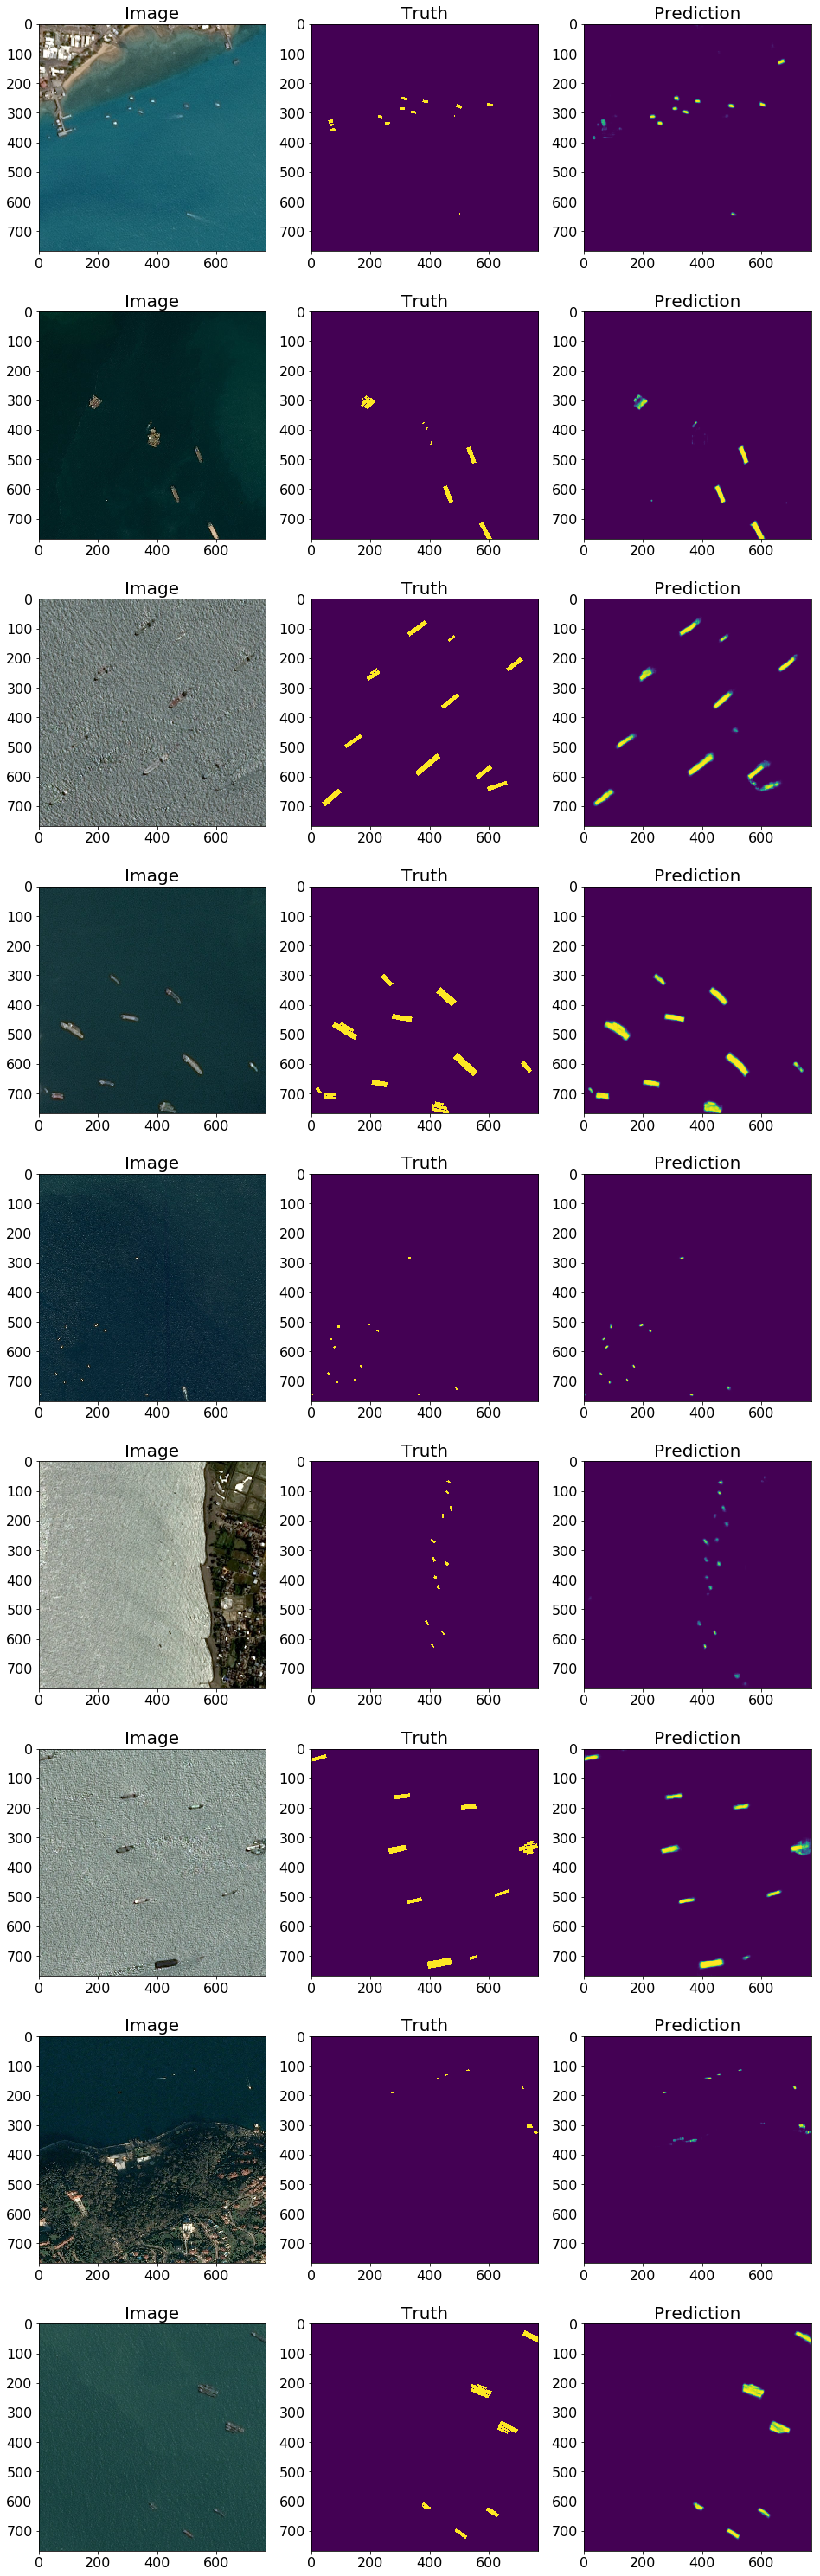

In [37]:
y_figsize = 6 * BATCH_SIZE
fig, m_axs = plt.subplots(BATCH_SIZE, 3, figsize=(16, y_figsize))
for (ax1, ax2, ax3), c_img, c_mask, c_hat in zip(m_axs, x_valid, y_valid, y_hat):
    ax1.imshow(c_img)
    ax1.set_title('Image')
    ax2.imshow(c_mask[:, :, 0])
    ax2.set_title('Truth')
    ax3.imshow(c_hat[:, :, 0])
    ax3.set_title('Prediction')

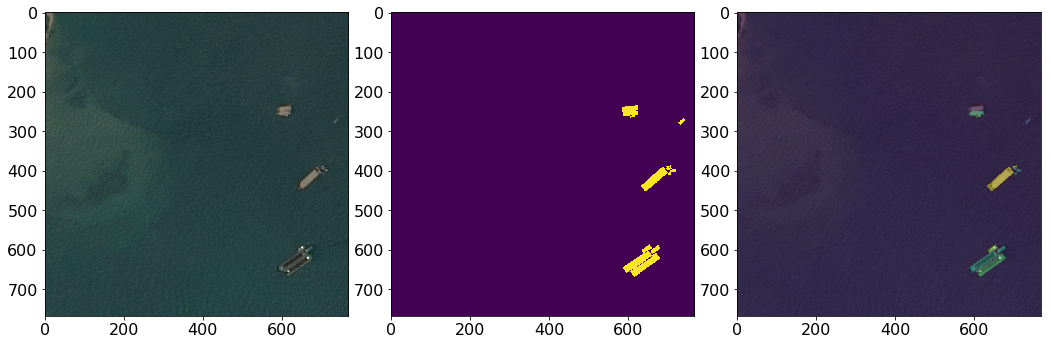

In [107]:
fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(merged_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

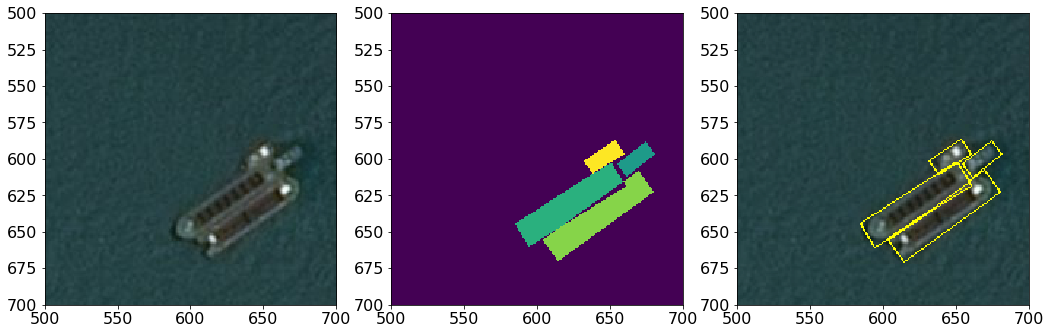

In [108]:
x1, x2 = 500, 700
y1, y2 = 500, 700
c_img = img[y1:y2,x1:x2]
c_msk = merged_masks[y1:y2,x1:x2]
bnd = mark_boundaries(img, merged_masks.astype(int), mode='outer', background_label=0)
c_bnd = bnd[y1:y2,x1:x2]

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].imshow(c_img, extent=[x1, x2, y2, y1])
axarr[1].imshow(c_msk, extent=[x1, x2, y2, y1])
axarr[2].imshow(c_img, extent=[x1, x2, y2, y1])
axarr[2].imshow(c_bnd, extent=[x1, x2, y2, y1])
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

$$\frac{1}{|thresholds|}\sum_{t}F_2(t)$$

In [ ]:
threshes = (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95)
def avg_f2_score(y_true, y_pred):
    f2_score = fbeta(y_true, y_pred, 2)

In [5]:
masks = pd.read_csv(os.path.join(ship_dir, 'train_ship_segmentations_v2_cleaned.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

229696 masks found
191987


ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [6]:
images_with_ship = masks.ImageId[masks.EncodedPixels.isnull() == False]
images_with_ship = np.unique(images_with_ship.values)
print('There are ' +str(len(images_with_ship)) + ' image files with masks')

There are 41988 image files with masks


In [8]:
ImageId = images_with_ship[i]
rle_0 = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels']#.tolist()

In [111]:
hierarchy

array([[[-1, -1, -1, -1]]], dtype=int32)

In [ ]:
plotme = 1

for i in tqdm(range(0, 1000)):
    ImageId = images_with_ship[i]

    img_0 = cv2.imread(os.path.join(train_image_dir, ImageId))
    img_0 = cv2.cvtColor(img_0, cv2.COLOR_BGR2RGB)
    rle_0 = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels']#.tolist()
    mask_0 = masks_as_image(rle_0)

    lbl_0, lbl_cnt = ndi.label(mask_0)
    props = regionprops(lbl_0)#, coordinates='rc')
    if lbl_cnt < 12 or props[0].area < 5000:
        continue

    if plotme == 1:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 10))
        
    print ('Image', ImageId, lbl_cnt)
    
    img_box = np.zeros_like(mask_0)
    for i in range(1, lbl_cnt+1):
        ship_mask = np.where(lbl_0 == i, 1, 0).astype(np.uint8)
        _, cnts, hierarchy = cv2.findContours(ship_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        rect = cv2.minAreaRect(cnts[0])
        box = cv2.boxPoints(rect)
        box = np.int0(box)

        if plotme == 1:
            cv2.drawContours(img_box, [box], 0, 1, -1)
        
    if plotme == 1:
        ax1.imshow(img_0)
        ax1.imshow(mask_0[...,0], cmap='gray', alpha=0.5)
        ax1.set_title('Image + Mask')
        ax2.imshow(img_0)
        ax2.imshow(img_box[..., 0], cmap='gray', alpha=0.5)
        ax2.set_title('Image + Bbox')
        plt.show()
        break

In [ ]:
def mask_to_bbox(mask):
    img_box = np.zeros_like(mask)
    _, cnt, _ = cv2.findContours(mask, 1, 2)
    rect = cv2.minAreaRect(cnt[0])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_box, [box], 0, 1, -1)
    return img_box

In [ ]:
bboxs = bboxes_dict[image]
    for bbox in bboxs:
        cv2.rectangle(img_1, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (255, 0, 0), 2)

In [ ]:
plotme = 0
rot_bboxes_dict = {}

for i in tqdm(range(0, len(images_with_ship))):
    image = images_with_ship[i]

    if plotme == 1:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = cv2.imread(train_image_dir+'/' + image)
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    #
    # 
    lbl_0, lbl_cnt = label(mask_0, return_num=True) 
    #props = regionprops(lbl_0)
    img_1 = img_0.copy()
    bboxes = []
    for i in range(1, lbl_cnt+1):
        mask = np.array((lbl_0 == i).astype('uint8')[..., 0])
        mask = cv2.resize(mask, (768, 768))
        _, cnts, hierarchy = cv2.findContours((255*mask).astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        rect = cv2.minAreaRect(cnts[0])
        if rect[1][1]>rect[1][0]:
            angle = 90-rect[2]
        else:
            angle = -rect[2]
        box = cv2.boxPoints(rect)
        #print (box)
        box = np.int0(box)

        if plotme == 1:
            cv2.drawContours(img_1,[box],0,(0,191,255),2)
        x = int(rect[0][0])
        y = int(rect[0][1])
        if plotme == 1:
            cv2.circle(img_1, ( x, y ), 5, (255, 0, 0), 3)
        bboxes.append([rect[0][0], rect[0][1], rect[1][0], rect[1][1], angle])
        
    rot_bboxes_dict[image] = bboxes.copy()
    if plotme == 1:
        ax1.imshow(img_0)
        ax1.set_title('Image')
        ax2.set_title('Mask')
        ax3.set_title('Image with derived bounding box')
        ax2.imshow(mask_0[...,0], cmap='gray')
        ax3.imshow(img_1)
        plt.show()